## Table of Contents

<ol>
    <li>
        <a href="#Introduction">Introduction</a>
    </li>
    <li>
        <a href="#Preparing-the-data">Preparing the data</a>
    </li>
    <li>
        <a href="#Fine-tuning-the-model-with-the-Trainer-API">Fine-tuning the model with the Trainer API</a>
    </li>
    <li>
        <a href="#Using-the-fine-tuned-model">Using the fine-tuned model</a>
    </li>
    <li>
        <a href="#Fine-tuning-the-model-with-Keras">Fine-tuning the model with Keras</a>
    </li>
    <li>
        <a href="#A-custom-training-loop">A custom training loop</a>
    </li>
</ol>

## Introduction

Let’s now dive into translation. This is another [sequence-to-sequence](https://huggingface.co/course/chapter1/7) task, which means it’s a problem that can be formulated as going from one sequence to another. In that sense the problem is pretty close to [summarization](https://huggingface.co/course/chapter7/6), and you could adapt what we will see here to other sequence-to-sequence problems such as:

- Style transfer: Creating a model that translates texts written in a certain style to another (e.g., formal to casual or Shakespearean English to modern English)

- Generative question answering: Creating a model that generates answers to questions, given a context

If you have a big enough corpus of texts in two (or more) languages, you can train a new translation model from scratch like we will in the section on [causal language modeling](https://huggingface.co/course/chapter7/6). It will be faster, however, to fine-tune an existing translation model, be it a multilingual one like mT5 or mBART that you want to fine-tune to a specific language pair, or even a model specialized for translation from one language to another that you want to fine-tune to your specific corpus.

In this section, we will fine-tune a Marian model pretrained to translate from English to French (since a lot of Hugging Face employees speak both those languages) on the [KDE4 dataset](https://huggingface.co/datasets/kde4), which is a dataset of localized files for the [KDE apps](https://apps.kde.org/). The model we will use has been pretrained on a large corpus of French and English texts taken from the [Opus dataset](https://opus.nlpl.eu/), which actually contains the [KDE4 dataset](https://opus.nlpl.eu/). But even if the pretrained model we use has seen that data during its pretraining, we will see that we can get a better version of it after fine-tuning.

Once we’re finished, we will have a model able to make predictions like this one:

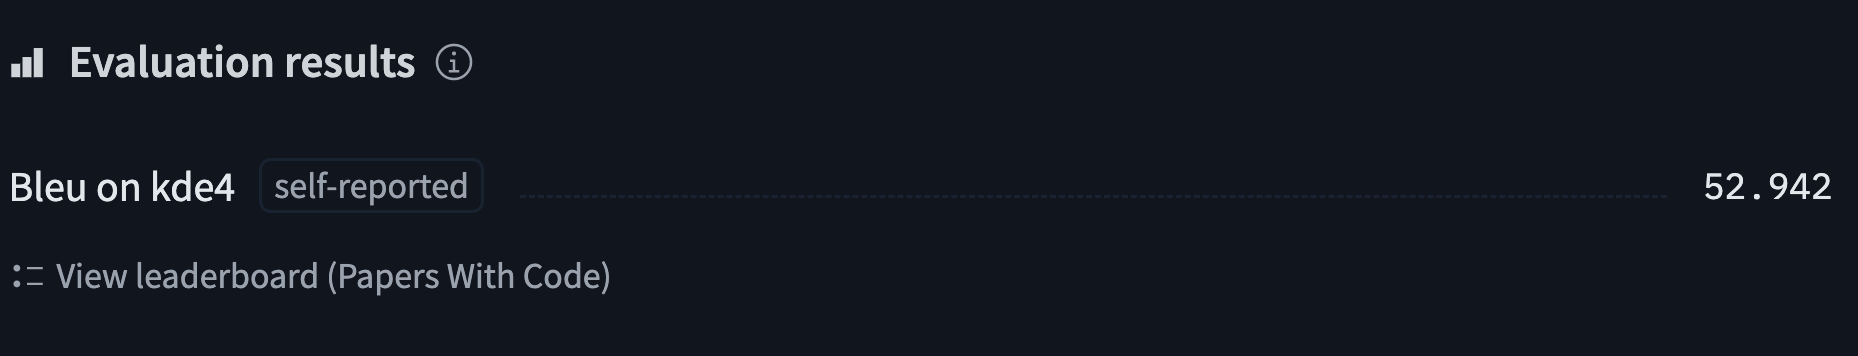

As in the previous sections, you can find the actual model that we’ll train and upload to the Hub using the code below and double-check its predictions [here](https://huggingface.co/huggingface-course/marian-finetuned-kde4-en-to-fr?text=This+plugin+allows+you+to+automatically+translate+web+pages+between+several+languages.).

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
Tesla P40


## Preparing the data

To fine-tune or train a translation model from scratch, we will need a dataset suitable for the task. As mentioned previously, we’ll use the [KDE4 dataset](https://huggingface.co/datasets/kde4) in this section, but you can adapt the code to use your own data quite easily, as long as you have pairs of sentences in the two languages you want to translate from and into. Refer back to [Chapter 5](https://huggingface.co/course/chapter5) if you need a reminder of how to load your custom data in a `Dataset`.

###  The KDE4 dataset

As usual, we download our dataset using the `load_dataset()` function:

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr")

README.md:   0%|          | 0.00/5.10k [00:00<?, ?B/s]

kde4.py:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

The repository for kde4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kde4.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

If you want to work with a different pair of languages, you can specify them by their codes. A total of 92 languages are available for this dataset; you can see them all by expanding the language tags on its [dataset card](https://huggingface.co/datasets/kde4).

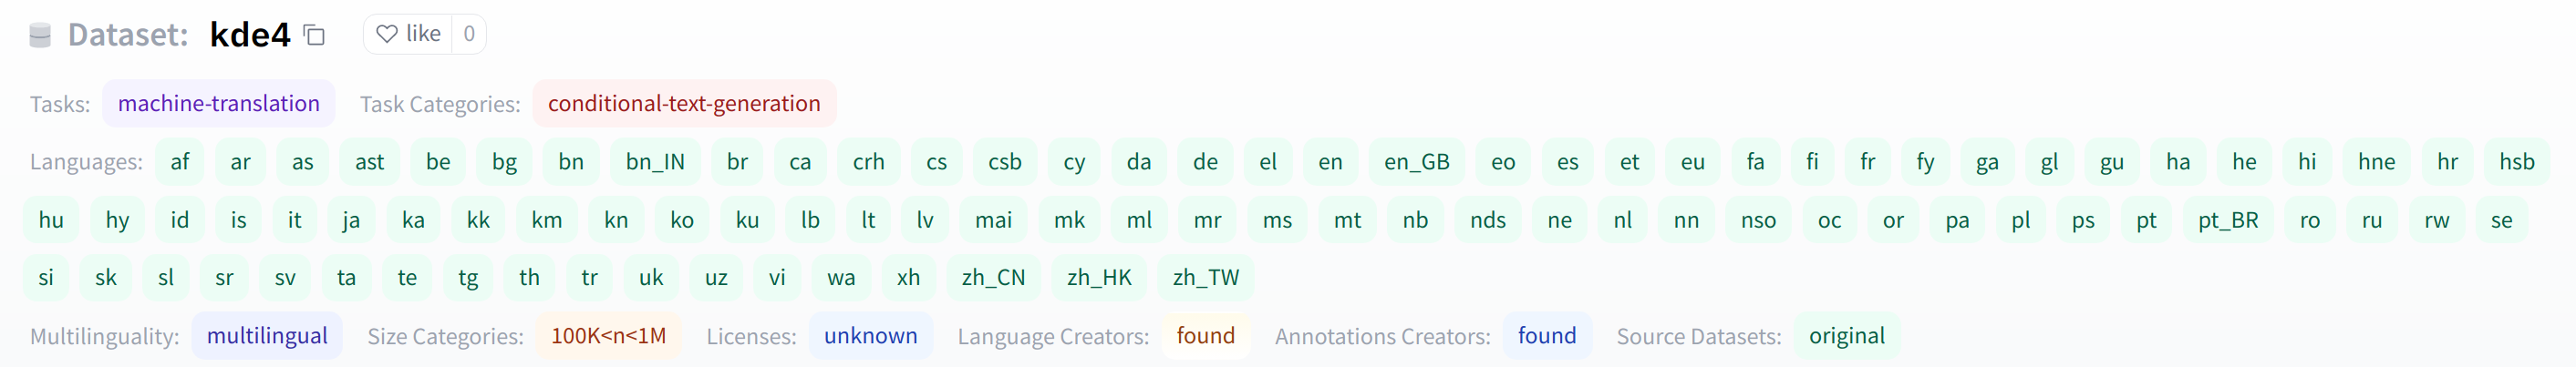

Let’s have a look at the dataset:

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

We have 210,173 pairs of sentences, but in one single split, so we will need to create our own validation set. As we saw in [Chapter 5](https://huggingface.co/course/chapter5), a `Dataset` has a `train_test_split()` method that can help us. We’ll provide a seed for reproducibility:

In [4]:
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 189155
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 21018
    })
})

We can rename the "test" key to "validation" like this:

In [5]:
split_datasets["validation"] = split_datasets.pop("test")

Now let’s take a look at one element of the dataset:

In [6]:
split_datasets["train"][1]["translation"]

{'en': 'Default to expanded threads',
 'fr': 'Par défaut, développer les fils de discussion'}

We get a dictionary with two sentences in the pair of languages we requested. One particularity of this dataset full of technical computer science terms is that they are all fully translated in French. However, French engineers leave most computer science-specific words in English when they talk. Here, for instance, the word “threads” might well appear in a French sentence, especially in a technical conversation; but in this dataset it has been translated into the more correct “fils de discussion.” The pretrained model we use, which has been pretrained on a larger corpus of French and English sentences, takes the easier option of leaving the word as is:

In [8]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/home/loc/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'translation_text': 'Par défaut pour les threads élargis'}]

Another example of this behavior can be seen with the word “plugin,” which isn’t officially a French word but which most native speakers will understand and not bother to translate. In the KDE4 dataset this word has been translated in French into the more official “module d’extension”:

In [9]:
split_datasets["train"][172]["translation"]

{'en': 'Unable to import %1 using the OFX importer plugin. This file is not the correct format.',
 'fr': "Impossible d'importer %1 en utilisant le module d'extension d'importation OFX. Ce fichier n'a pas un format correct."}

Our pretrained model, however, sticks with the compact and familiar English word:

```
translator(
    "Unable to import %1 using the OFX importer plugin. This file is not the correct format."
)
```

It will be interesting to see if our fine-tuned model picks up on those particularities of the dataset (spoiler alert: it will).

###  Processing the data

## Fine-tuning the model with the Trainer API

## Using the fine-tuned model

## Fine-tuning the model with Keras

## A custom training loop